<a href="https://colab.research.google.com/github/joeycato/pixelbasedalignment/blob/main/DirectPixelBasedAlignmentExperiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Attempt to correct the wavy image by sweeping through the pixel columns left to right and choosing the most optimal vertical offset ( as determined by the color difference with the left neighbor column )

Special Thanks to [/u/smushkan](https://old.reddit.com/user/smushkan) for proposing the idea!

Reference for scoring method:
https://www.microsoft.com/en-us/research/wp-content/uploads/2004/10/tr-2004-92.pdf

In [ ]:
pip install colormath

  Created wheel for colormath: filename=colormath-3.0.0-cp37-none-any.whl size=39391 sha256=ef99a25dc74a20bc0815b2d6d2749ddaca37308d0059c0a458108c855843600d
  Stored in directory: /root/.cache/pip/wheels/20/49/7b/9635bccd6136cc713f623caa85ced89c0c63878f8b2a58fe99
Successfully built colormath


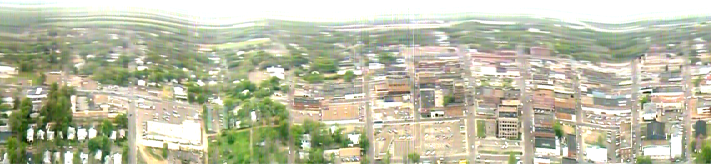

In [ ]:
from PIL import Image
import urllib.request as urllib2
img = Image.open(urllib2.urlopen('https://i.imgur.com/7TIpiRc.png')) # paris flyover

IMG_WIDTH = img.width
IMG_HEIGHT = img.height

# show input image
img

100% (711 of 711) |######################| Elapsed Time: 0:05:04 ETA:  00:00:00

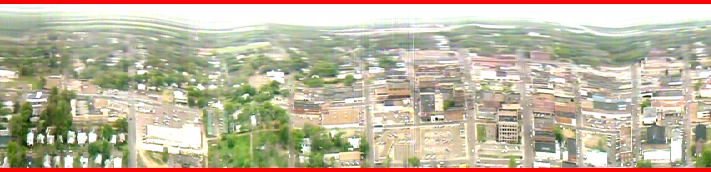

In [ ]:
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000
import math
import progressbar

# number of pixels a column is allowed to vertically shift in one direction
MAX_SHIFT_RANGE = 4
# portion of image to to process
# full width takes about ~5 minutes to process, so you may want to
# set to a smaller value for experimental changes
MAX_IMAGE_WIDTH_TO_ALIGN = IMG_WIDTH  # Default value: IMG_WIDTH

# create target image (filled with red)
target = Image.new('RGB', (IMG_WIDTH, IMG_HEIGHT + 2 * MAX_SHIFT_RANGE), "red")
pixels = target.load()

# convert RGB to LAB
def getColorLAB(pixel):
    r, g, b = pixel
    return convert_color(sRGBColor(r/255, g/255, b/255), LabColor)

# supposedly the most accurate way to measure human perceptible color difference
def getColorDifferenceLAB(a, b):
    a_lab = getColorLAB(a)
    b_lab = getColorLAB(b)
    return delta_e_cie2000(a_lab, b_lab)

bar = progressbar.ProgressBar(max_value=MAX_IMAGE_WIDTH_TO_ALIGN,redirect_stdout=True)

# sweep through the the pixel columns left to right
for x in range(MAX_IMAGE_WIDTH_TO_ALIGN):
    bar.update(x+1)
    img_column_strip = img.crop((x, 0, x+1, IMG_HEIGHT))
    pixel_column = img_column_strip.convert('RGB').load()
    BEST_SCORE = 99999999999
    if (x == 0):
        target.paste(img_column_strip, (x, MAX_SHIFT_RANGE))
    else:
        # Find the best y-offset for the pixel strip which yields
        # the smallest color difference ( when compared against the
        # left neighboring pixel column )
        for y in range(2 * MAX_SHIFT_RANGE):
            sum = 0
            num_pairs_compared = 0
            for j in range(IMG_HEIGHT):
                r1, g1, b1 = pixel_column[0, j]
                r2, g2, b2 = pixels[x-1, y+j]
                # skip any non-overlapped comparisions ( based on red pixel )
                if (not(r2 == 255 and g2 == 0 and b2 == 0)):
                    num_pairs_compared = num_pairs_compared + 1
                    diff = getColorDifferenceLAB((r1, g1, b1), (r2, g2, b2))
                    # SSD approach ( sum of squared differences )
                    sum = sum + diff*diff

            # SSD tends to be biased towards smallest overlap, so correct
            # that by normalizing score to a per-pixel
            sum = sum / num_pairs_compared
            if (sum < BEST_SCORE):
                BEST_SCORE = sum
                BEST_Y = y
        y = BEST_Y
        # draw strip at best y-location
        target.paste(img_column_strip, (x, y))

# show output
target